# VARモデル
[statsmodel](https://www.statsmodels.org/dev/vector_ar.html)のチュートリアルをやってみる。

In [1]:
 # some example data
import numpy as np
import pandas
import statsmodels.api as sm
from statsmodels.tsa.api import VAR, DynamicVAR
from statsmodels.tsa.base.datetools import dates_from_str

# データの読み込み
mdata = sm.datasets.macrodata.load_pandas().data

# prepare the dates index
dates = mdata[['year', 'quarter']].astype(int).astype(str)
quarterly = dates["year"] + "Q" + dates["quarter"]

quarterly = dates_from_str(quarterly)
mdata = mdata[['realgdp','realcons','realinv']]
mdata.index = pandas.DatetimeIndex(quarterly)
data = np.log(mdata).diff().dropna()

In [2]:
# 可視化

data.head()

,realgdp,realcons,realinv
1959-06-30,0.024942,0.015286,0.080213
1959-09-30,-0.001193,0.010386,-0.072131
1959-12-31,0.003495,0.001084,0.034425
1960-03-31,0.022190,0.009534,0.102664
1960-06-30,-0.004685,0.012572,-0.106694


ここまでで、3変数の時系列データが用意できている。  
これらの変数の相互関係をVARモデルで調べる。  

In [23]:
# make a VAR model
model = VAR(data)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)


In [26]:
# パラメータを指定して、学習。パラメータの詳細は下記のURLを参照。
# http://www.statsmodels.org/dev/generated/statsmodels.tsa.vector_ar.var_model.VAR.fit.html#statsmodels.tsa.vector_ar.var_model.VAR.fit
results = model.fit(# maxlags=12, # Maximum number of lags to check for order selection, defaults to 12 * (nobs/100.)**(1./4)
                   method='ols', # Estimation method to use
                   ic='aic', # Information criterion to use for VAR order selection.{'aic', 'fpe', 'hqic', 'bic', None}
                   trend='c', # “c” - add constant “ct” - constant and trend “ctt” - constant, linear and quadratic trend “nc” - co constant, no trend
                   verbose=True #  Print order selection output to the screen.(bool)
                   ) 

# 結果を表示
results.summary()

<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 3, BIC -> 1, FPE -> 3, HQIC -> 1>
Using 3 based on aic criterion


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 04, Jan, 2019
Time:                     11:39:11
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -27.4257
Nobs:                     199.000    HQIC:                  -27.7212
Log likelihood:           1961.15    FPE:                7.47593e-13
AIC:                     -27.9222    Det(Omega_mle):     6.45336e-13
--------------------------------------------------------------------
Results for equation realgdp
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.001281         0.001295            0.989           0.322
L1.realgdp         -0.286148         0.171582           -1.668           0.095
L1.realcons         0.673869         0.132245            5.096    

上記の結果で、なんとなく変数間の関係性がわかる。  
例えば、各変数ごとの**「過去の各変数との関係（係数）(coefficient)」**と**「係数が0である可能性（prob）」**が表示されている。  
また、一番下には相関係数が表示されている。

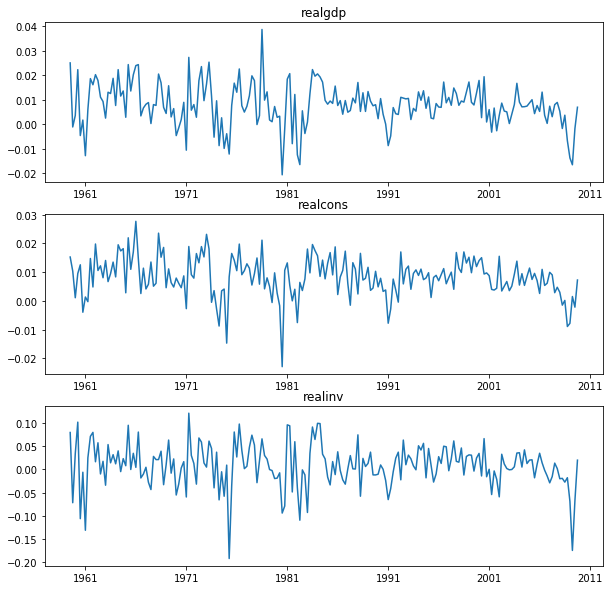

In [27]:
# 変数ごとの可視化
x = results.plot()

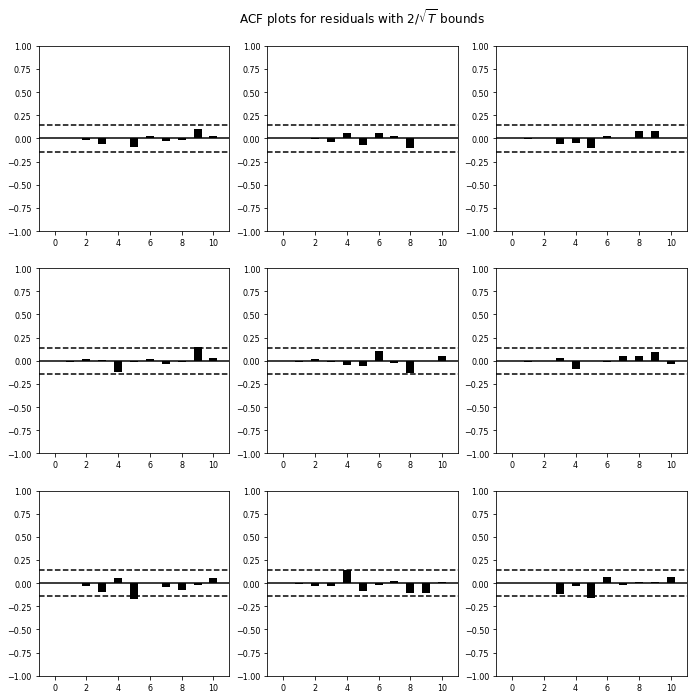

In [40]:
# 自己相関を可視化(偏自己相関ではないよ。注意!)
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.vector_ar.var_model.VARResults.plot_acorr.html#statsmodels.tsa.vector_ar.var_model.VARResults.plot_acorr

x = results.plot_acorr(nlags=10, # どれだけ過去の値まで相関を確認するか。「lag order」
                      resid=True,  # 残渣項の自己相関も確認するか
                       linewidth=8 # 棒グラフの太さ
                      )

In [44]:
# lag orderを指定して、AICを確認する。

model.select_order(15)
results = model.fit(maxlags=15, ic='aic') # lag orderの最大値を指定し、その範囲内で「AIC」で比較して、最良の尤度を出したものを結果として出力してくれる
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 04, Jan, 2019
Time:                     11:56:35
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -27.4257
Nobs:                     199.000    HQIC:                  -27.7212
Log likelihood:           1961.15    FPE:                7.47593e-13
AIC:                     -27.9222    Det(Omega_mle):     6.45336e-13
--------------------------------------------------------------------
Results for equation realgdp
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.001281         0.001295            0.989           0.322
L1.realgdp         -0.286148         0.171582           -1.668           0.095
L1.realcons         0.673869         0.132245            5.096    

残渣項の相関も計算している。VARモデルの場合、同時刻における残渣項の相関があることがあるので、この相関係数が大きくてもまあ大丈夫。

In [49]:
# 推論

lag_order = results.k_ar # Order of VAR process.上の学習で求めた、最良の次数が返ってくる。

# 全変数(realgdp,realcons,realinv)の予測値を取得
results.forecast(y=data.values[-lag_order:], 
                 steps=5 # 何時点先までの予測結果を得るか
                ) 

array([[ 0.00616044,  0.00500006,  0.00916198],
       [ 0.00427559,  0.00344836, -0.00238478],
       [ 0.00416634,  0.0070728 , -0.01193629],
       [ 0.00557873,  0.00642784,  0.00147152],
       [ 0.00626431,  0.00666715,  0.00379567]])

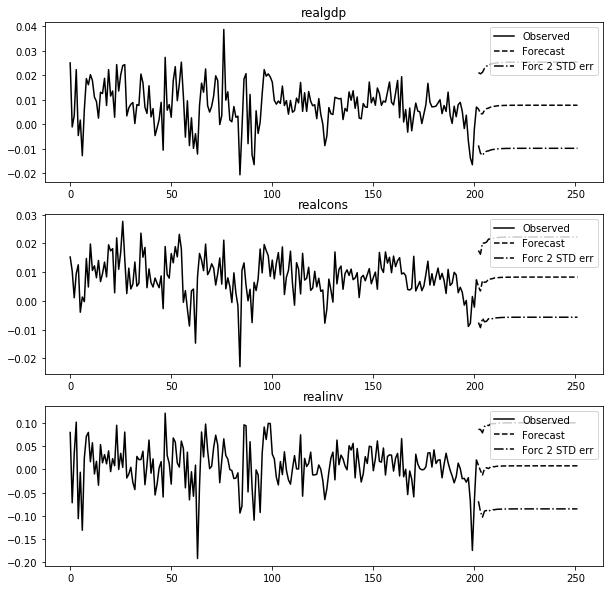

In [68]:
# 実測値、予測値、信頼区間を出力
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.vector_ar.var_model.VARResults.html

x = results.plot_forecast(steps=50)

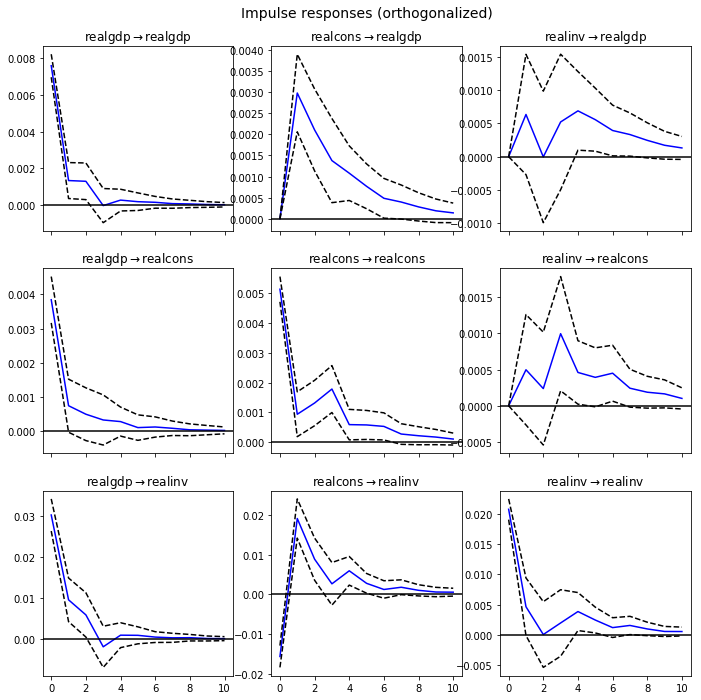

In [63]:
# インパルス応答関数
# ある変数にショックを与えた時に、他の変数にどのような影響が出るのか、を予測する。

irf = results.irf(periods=10) # Analyze impulse responses to shocks in system

x = irf.plot(orth=True, # 直行化するか否か
             signif=0.1 # 出力する信頼区間の幅
            ) 

インパルス応答関数の見方については、**横軸が「時系列」、縦軸が「影響度」**と解釈すると良い。  
例えば、上記の例だと、「reallinv」が上昇すると、少し遅れて「realgdp」、「realcons」が上昇する、といった傾向がわかる。

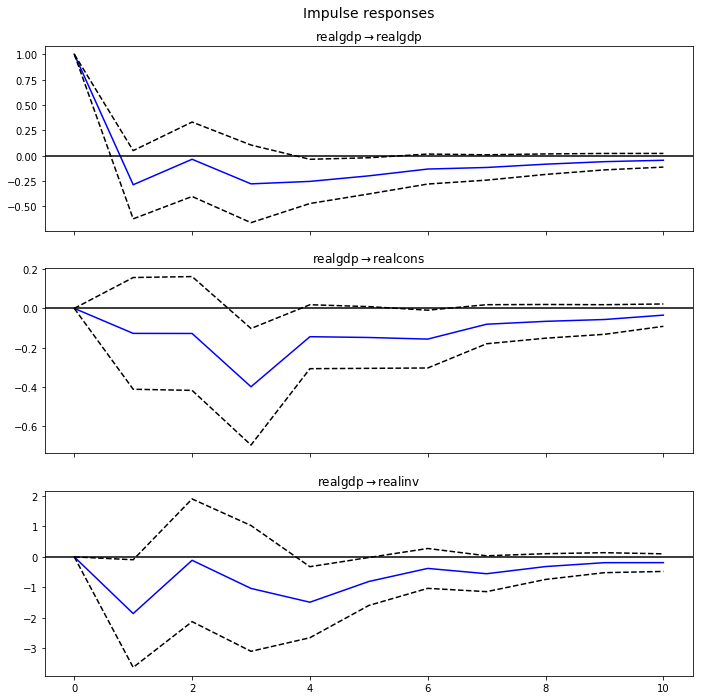

In [65]:
# インパルス応答関数
# 見たい変数だけに限定することも可能

x = irf.plot(impulse='realgdp')

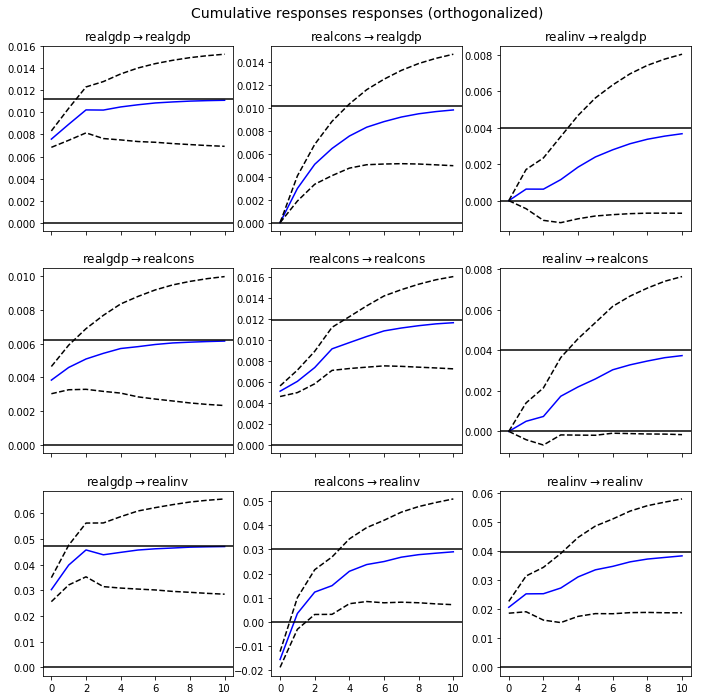

In [66]:
# 累積インパルス応答関数を可視化
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.vector_ar.irf.IRAnalysis.plot_cum_effects.html

x = irf.plot_cum_effects(orth=True,
                        signif=0.05, # 信頼区間
                        )

# 予測誤差分散分解

よくわからん...。  
「時系列分析と状態空間モデルの基礎　RとStanで学ぶ理論と実装」のp.159によると下記のように書いてある。  

>相手のデータの影響をどれほど受けているかを調べる方法もあります。
これを分散分解と呼びます。

つまり、各変数間で、相手の変数の予測にどれだけ影響を与えるか、というのを指定したステップ数で計算するもののようだ。  
というより、VARを使う際の強みとなるのはこれをして**「変数間の関係性を確認する」**ということができる点にあるみたい。

In [70]:
fevd = results.fevd(5)
fevd.summary()

FEVD for realgdp
      realgdp  realcons   realinv
0    1.000000  0.000000  0.000000
1    0.864889  0.129253  0.005858
2    0.816725  0.177898  0.005378
3    0.793647  0.197590  0.008763
4    0.777279  0.208127  0.014594

FEVD for realcons
      realgdp  realcons   realinv
0    0.359877  0.640123  0.000000
1    0.358767  0.635420  0.005813
2    0.348044  0.645138  0.006817
3    0.319913  0.653609  0.026478
4    0.317407  0.652180  0.030414

FEVD for realinv
      realgdp  realcons   realinv
0    0.577021  0.152783  0.270196
1    0.488158  0.293622  0.218220
2    0.478727  0.314398  0.206874
3    0.477182  0.315564  0.207254
4    0.466741  0.324135  0.209124




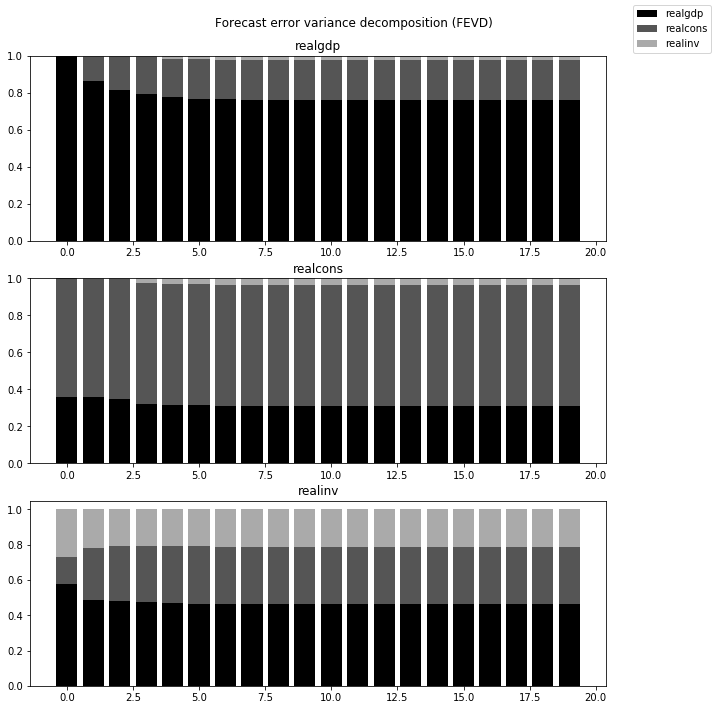

In [72]:
# FEVDの可視化
x = results.fevd(periods=20).plot()

# 仮説検定
「Granger因果性検定」をやる

In [109]:
# 原因、影響がありそうな変数を指定する。
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.vector_ar.var_model.VARResults.test_causality.html
x= results.test_causality(caused= 'realgdp',  # 原因となる要素
                          # causing= ['realinv', 'realcons'],  # 影響を受ける要素
                          causing= 'realinv',  # 影響を受ける要素
                          kind='f', # 仮説検定のアルゴリズム
                         signif=0.05 # 信頼区間
                         )

print('他の変数から影響を及ぼされた変数:{}'.format(x.causing))
print('他の変数に影響を及ぼす変数:{}'.format(x.caused))
print('テスト結果:{}'.format(x.test_statistic))
print('棄却値:{}'.format(x.crit_value))
print('p値:{}'.format(x.pvalue))
print('自由度:{}'.format(x.df))
print('信頼区間:{}'.format(x.signif))
print('テストのアルゴリズム:{}'.format(x.test))
print('仮説検定の手法:{}'.format(x.method))

他の変数から影響を及ぼされた変数:['realinv']
他の変数に影響を及ぼす変数:['realgdp']
テスト結果:0.5631242445286401
棄却値:2.6206207179425736
p値:0.6395276123467494
自由度:(3, 567)
信頼区間:0.05
テストのアルゴリズム:granger
仮説検定の手法:F


上記の結果でp値が0.05よりも小さい場合は、因果関係があると考えることができる。  
つまり、上記の場合は「realgdp」が「realcons」の予測に役立っている、という意味合いでの因果関係があると言える。　　

普通なら、これで因果関係があった変数同士でインパルス応答関数を確認する流れになりそうなので、確認して見る。  

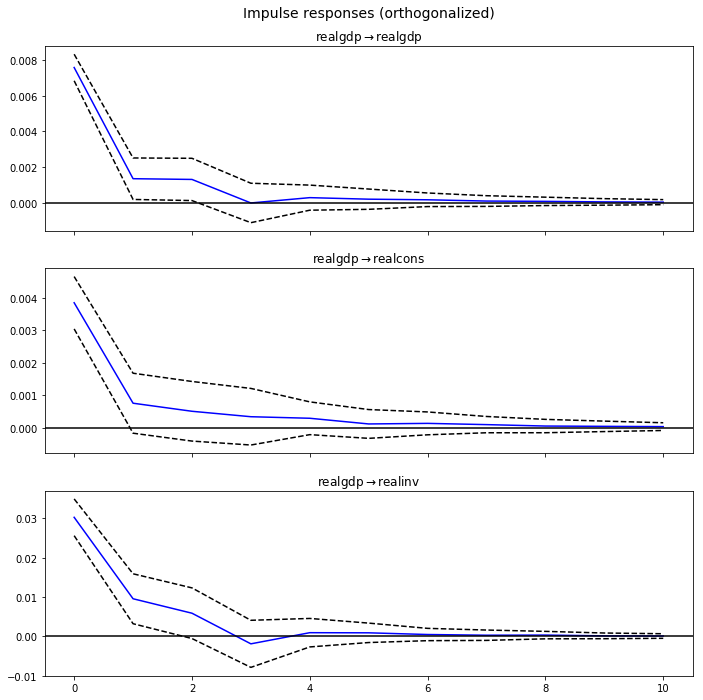

In [104]:
x = irf.plot(impulse='realgdp', orth=True)